In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

In [4]:
vl.__version__

'0.0.13-py36_0'

In [5]:
innov_dim = 250

## Load the data

In [6]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 252
    vol = store['discrete_vol_est'] * 252**2 
    
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [7]:
data.head()

,rtn,vol
2003-01-02,6.419615,8.799756
2003-01-03,0.539956,7.785992
2003-01-06,5.150512,4.586335
2003-01-07,-0.896750,8.294531
2003-01-08,-2.748119,6.446751


In [8]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,5.523276,-0.229847
vol,-0.229847,1.886587


In [9]:
data.corr()

,rtn,vol
rtn,1.000000,-0.024379
vol,-0.024379,1.000000


In [10]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.023421,5.621287
std,2.350165,14.458447
min,-20.781833,0.123335
25%,-0.954041,1.380618
50%,0.128299,2.416002
75%,1.099523,5.030940
max,18.031014,421.880784


In [90]:
stats.describe(data)

DescribeResult(nobs=3713, minmax=(array([-20.782,   0.123]), array([ 18.031, 421.881])), mean=array([0.023, 5.621]), variance=array([  5.523, 209.047]), skewness=array([-0.312, 12.209]), kurtosis=array([ 10.066, 240.401]))

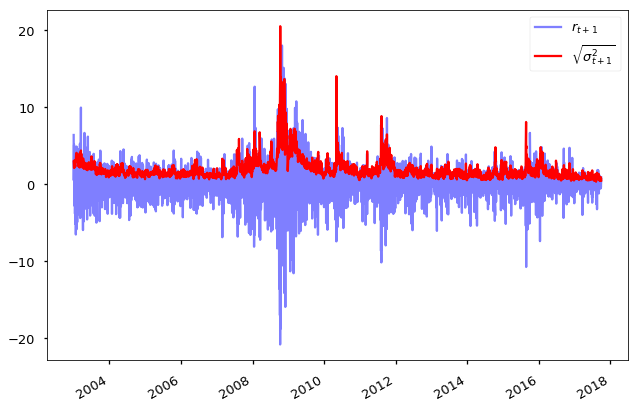

In [91]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1, color='blue', alpha=.5, label="$r_{t+1}$")
data['vol'].apply(np.sqrt).plot(ax=ax1, label='$\sqrt{\sigma^2_{t+1}}$', color='red')
ax1.legend()
fig1.savefig('../doc/figures/time_series.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

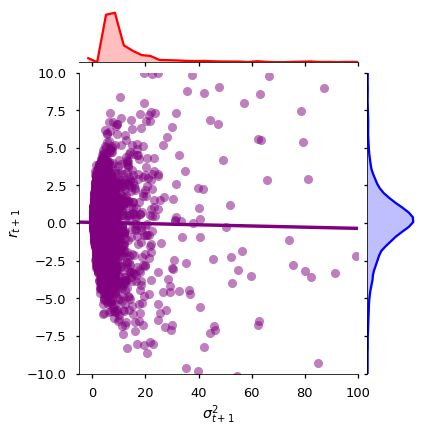

In [117]:
joint_grid = sns.JointGrid(x='vol', y='rtn', data=data, xlim=[-5, 100], ylim=[-10, 10])
joint_grid.plot_joint(sns.regplot, ci=None, color='purple', scatter_kws={"alpha":.5})
sns.kdeplot(data['vol'], ax=joint_grid.ax_marg_x, legend=None, shade=True, color='red')
sns.kdeplot(data['rtn'], ax=joint_grid.ax_marg_y, legend=None, shade=True, color='blue', vertical=True)
joint_grid.set_axis_labels("$\sigma^2_{t+1}$","$r_{t+1}$")
joint_grid.savefig('../doc/figures/joint_dist.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [118]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [119]:
pd.Series(omega)

gamma    0.259657
beta     0.111355
psi     -0.153739
zeta     0.908686
delta    0.267858
rho      0.807506
scale    3.112013
phi     -0.302417
pi      -0.115097
theta    0.516140
dtype: float64

In [120]:
pd.Series(omega) - 1.96 * pd.Series(np.sqrt(np.diag(omega_cov)), index=omega_cov.columns)

beta     0.092004
delta   -2.471916
gamma    0.209751
phi     -0.695048
pi      -0.450818
psi     -0.177685
rho      0.402264
scale   -1.155201
theta    0.407557
zeta     0.867994
dtype: float64

In [121]:
omega_cov

,beta,delta,gamma,phi,pi,psi,rho,scale,theta,zeta
beta,0.000097,0.000000,-0.000035,NaN,NaN,-0.000091,0.000000,0.000000,NaN,0.000000
delta,0.000000,1.953968,0.000000,NaN,NaN,0.000000,-0.275013,-2.536490,NaN,0.000000
gamma,-0.000035,0.000000,0.000648,NaN,NaN,-0.000080,0.000000,0.000000,NaN,0.000000
phi,NaN,NaN,NaN,0.040129,0.032396,NaN,NaN,NaN,0.008921,NaN
pi,NaN,NaN,NaN,0.032396,0.029339,NaN,NaN,NaN,0.005978,NaN
psi,-0.000091,0.000000,-0.000080,NaN,NaN,0.000149,0.000000,0.000000,NaN,0.000000
rho,0.000000,-0.275013,0.000000,NaN,NaN,0.000000,0.042748,0.326903,NaN,0.000000
scale,0.000000,-2.536490,0.000000,NaN,NaN,0.000000,0.326903,4.739982,NaN,0.000000
theta,NaN,NaN,NaN,0.008921,0.005978,NaN,NaN,NaN,0.003069,NaN
zeta,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000431


In [122]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.123335
2017-09-14    0.214673
2017-09-22    0.216867
2016-11-25    0.226227
2017-07-24    0.242692
Name: vol, dtype: float64

In [123]:
omega2, omega_cov2 = vl.estimate_params(data)

In [125]:
omega2

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'delta': 0.2678579804909869,
 'rho': 0.8075059188831978,
 'scale': 3.1120129274168016}

In [124]:
qlr_stats = vl.compute_qlr_stats(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
                                 pi_min=-.25, pi_max=0, theta_min=.2, theta_max=.6,  use_tqdm=True)
                               


In [176]:
# qlr_draws = vl.compute_qlr_sim(omega=omega2, omega_cov=omega_cov2, theta_dim=10, pi_dim=10, phi_dim=10, 
#                                innov_dim=innov_dim, pi_min=-.25, pi_max=0, theta_min=.2, theta_max=.6,
#                                use_tqdm=True, alpha=0.05)

In [194]:
np.sort(qlr_stats.phi.unique()) - np.sort(qlr_draws.phi.unique())

array([0.000e+00, 0.000e+00, 1.110e-16, 1.110e-16, 0.000e+00, 0.000e+00,
       1.110e-16, 5.551e-17, 2.776e-17, 0.000e+00])

In [204]:
qlr_stats.set_index(['phi', 'pi', 'theta']).head()

qlr
phi  pi    theta        
-0.9 -0.25 0.511111  inf
           0.377778  inf
           0.333333  inf
           0.244444  inf
           0.422222  inf

In [207]:
qlr_stats.count()

phi      1000
pi       1000
theta    1000
qlr      1000
dtype: int64

In [255]:
qlr_stats.sort_values(by=['phi', 'pi', 'theta'], inplace=True)
qlr_draws.sort_values(by=['phi', 'pi', 'theta'], inplace=True)
close_enough = np.allclose(qlr_stats[['phi', 'pi', 'theta']], qlr_draws[['phi', 'pi', 'theta']])

if not close_enough:
    raise RuntimeError('The indices are not the same!!!')
    
else:
    qlr_stats[['phi', 'pi', 'theta']] = qlr_draws[['phi', 'pi', 'theta']]
    
    
merged_values = pd.merge(qlr_stats, qlr_draws,left_on=['phi', 'pi', 'theta'], right_on=['phi', 'pi', 'theta'],
                         suffixes=['_draws', '_stats'])

In [267]:
qlr_stats.sort_values(by='qlr')

,phi,pi,theta,qlr
657,-0.3,-0.111111,0.422222,0.041189
648,-0.3,-0.138889,0.600000,1.399743
687,-0.3,-0.027778,0.511111,2.241040
606,-0.3,-0.250000,0.466667,2.278916
666,-0.3,-0.083333,0.244444,2.302626
615,-0.3,-0.222222,0.422222,3.086692
676,-0.3,-0.055556,0.466667,3.092439
646,-0.3,-0.138889,0.422222,3.590907
696,-0.3,0.000000,0.466667,3.786496
607,-0.3,-0.250000,0.511111,4.428556


In [266]:
qlr_draws.sort_values(by='qlr')

,phi,pi,theta,qlr
97,-0.8,-0.250000,0.377778,0.000000
30,-0.9,-0.166667,0.511111,0.000000
31,-0.9,-0.166667,0.555556,0.000000
32,-0.9,-0.166667,0.600000,0.000000
41,-0.9,-0.138889,0.555556,0.000000
42,-0.9,-0.138889,0.600000,0.000000
96,-0.8,-0.250000,0.333333,0.000000
201,-0.7,-0.250000,0.555556,0.000000
98,-0.8,-0.250000,0.422222,0.000000
99,-0.8,-0.250000,0.466667,0.000000


In [264]:
merged_values

,phi,pi,theta,qlr_draws,qlr_stats
0,-0.9,-0.250000,0.200000,1506.574634,6.559266
1,-0.9,-0.250000,0.244444,inf,0.000000
2,-0.9,-0.250000,0.288889,inf,0.000000
3,-0.9,-0.250000,0.333333,inf,0.000000
4,-0.9,-0.250000,0.377778,inf,0.000000
5,-0.9,-0.250000,0.422222,inf,0.000000
6,-0.9,-0.250000,0.466667,inf,0.000000
7,-0.9,-0.250000,0.511111,inf,0.000000
8,-0.9,-0.250000,0.555556,inf,0.000000
9,-0.9,-0.250000,0.600000,inf,0.000000


In [268]:
accepted_vals = merged_values.query('qlr_stats > qlr_draws').drop(['qlr_draws', 'qlr_stats'], axis='columns')

In [269]:
# qlr_draws.to_json(f'../results/qlr_draws_on_data_{innov_dim}_smaller_region.json')

In [270]:
qlr_draws = pd.read_json('../results/qlr_draws_on_data_250_smaller_region.json')

In [271]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [272]:
accepted_vals

,phi,pi,theta
606,-0.3,-0.250000,0.466667
607,-0.3,-0.250000,0.511111
609,-0.3,-0.250000,0.600000
615,-0.3,-0.222222,0.422222
645,-0.3,-0.138889,0.422222
646,-0.3,-0.138889,0.466667
649,-0.3,-0.138889,0.600000
655,-0.3,-0.111111,0.422222
661,-0.3,-0.083333,0.244444
667,-0.3,-0.083333,0.511111


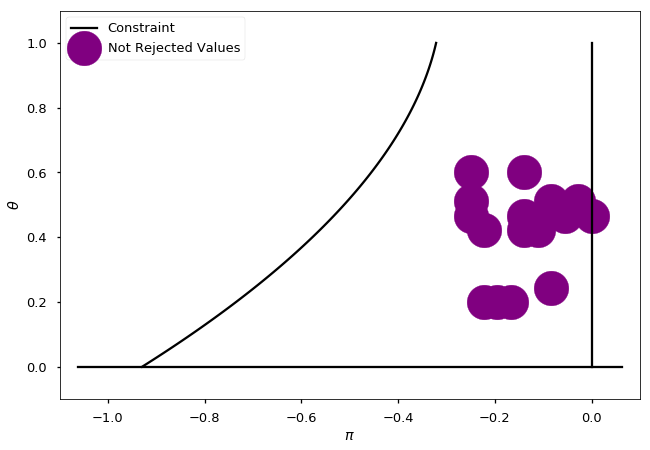

In [293]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.theta, x=accepted_vals.pi, marker='o', s=1200, label='Not Rejected Values',
           color='purple')
ax3.set_xlim([-3.5, .5])
ax3.set_ylim([-.5, 3.5])
yvals = np.linspace(0,1,100)
xvals = [constraint(omega['scale'], omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='black', label='Constraint')
ax3.axvline(0,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axvline(-15,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axhline(0,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.axhline(5,  xmin=.5 /16, xmax=1 - .5/16, color='black')

ax3.set_ylabel(r'$\theta$')
ax3.set_xlabel(r'$\pi$')
ax3.set_ylim([-0.1, 1.1])
ax3.set_xlim([-1.1, 0.1])
ax3.legend()

fig3.savefig('../doc/figures/confidence_region.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [274]:
accepted_vals.min()

phi     -0.30
pi      -0.25
theta    0.20
dtype: float64

In [275]:
accepted_vals.max()

phi     -0.2
pi       0.0
theta    0.6
dtype: float64